**W266 DETOX BART FROM MON**

In [1]:
# Install these packages if running from colab
!pip install tensorflow-datasets --quiet
!pip install pydot --quiet
!pip install transformers --quiet

# install huggingface datasets
!pip install datasets --quiet

! pip install rouge-score nltk --quiet
! pip install huggingface_hub --quiet



     |████████████████████████████████| 5.5 MB 20.9 MB/s 
     |████████████████████████████████| 7.6 MB 39.0 MB/s 
     |████████████████████████████████| 182 kB 41.9 MB/s 
     |████████████████████████████████| 451 kB 36.1 MB/s 
     |████████████████████████████████| 115 kB 75.0 MB/s 
     |████████████████████████████████| 212 kB 74.3 MB/s 
     |████████████████████████████████| 127 kB 71.0 MB/s 


In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import sklearn as sk
import os
import nltk
from nltk.data import find
import matplotlib.pyplot as plt
import re

import transformers
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint 
from transformers import BertTokenizer, TFBertModel

In [3]:
# get paradetox dataset
# the toxic parallel dataset
from datasets import load_dataset, load_metric

dataset = load_dataset("SkolkovoInstitute/paradetox", split="train")
dataset = dataset.train_test_split(test_size=0.1, shuffle=True)
metric = load_metric("rouge")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/SkolkovoInstitute___csv/SkolkovoInstitute--paradetox-2d7856e905be458c/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  import sys


In [4]:
dataset


DatasetDict({
    train: Dataset({
        features: ['en_toxic_comment', 'en_neutral_comment'],
        num_rows: 17789
    })
    test: Dataset({
        features: ['en_toxic_comment', 'en_neutral_comment'],
        num_rows: 1977
    })
})

In [5]:
pd.DataFrame(dataset['train'])

,en_toxic_comment,en_neutral_comment
0,"fuck u shithead , we have real people being sa...","we have real people being saved , women &amp c..."
1,that 's fuckin hilarious l heroes !,That's very hilarious I heroes!
2,why the fuck is obama sending them u,why is obama sending them u
3,almost ripped my head off like shit ! smh .,almost got my head scratched
4,"schandelmeier , who are you trying to impress ...","schandelmeier , who are you trying to impress ..."
...,...,...
17784,"thats fucking it , im joining",It is that I'm joining.
17785,come on bring ya horny ass lol,Come on.
17786,i 'm not doing shit friday cept smokin some he...,i 'm not doing anything friday except smoking ...
17787,sorry stupid behaviour doesnt end with car dri...,sorry bad behaviour doesnt end with car drivers .


**BERT TWEET MODEL FROM ANSTONIA**

In [6]:
url = 'https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv'
df = pd.read_csv(url, index_col=0)
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


# Field Description from  Davidson et.al github

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

Very large skew towards offensive langauge in the dataset

In [94]:
training_tweets, testing_tweets = train_test_split(df, test_size=0.2, random_state=25)
valid_tweets, testing_tweets = train_test_split(testing_tweets, test_size = 0.5, random_state=25)

In [95]:
print(f"No. of training examples: {training_tweets.shape[0]}")
print(f"No. of validation examples: {valid_tweets.shape[0]}")
print(f"No. of testing examples: {testing_tweets.shape[0]}")

No. of training examples: 19826
No. of validation examples: 2478
No. of testing examples: 2479


In [96]:
training_tweets['tweet'].apply(lambda x: len(x)).mean()

85.46645818622011

In [89]:
#make it easier to use a variety of BERT subword models
# model_checkpoint = 'bert-base-cased'
model_checkpoint = "vinai/bertweet-base"

In [90]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained("vinai/bertweet-base")

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFBertModel: ['lm_head', 'roberta']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [91]:
max_length = 80

In [ ]:
list(training_tweets['tweet'].apply(lambda x: str(x)))

In [14]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(list(training_tweets['tweet'].apply(lambda x: str(x))), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(list(valid_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(list(testing_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [15]:
def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                hidden_size = 201, 
                                dropout=0.3,
                                learning_rate=0.00005):
  """
  Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
  """
  bert_model = TFBertModel.from_pretrained(checkpoint)                                              
  ### YOUR CODE HERE

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  bert_inputs = {'input_ids': input_ids,
  'token_type_ids': token_type_ids,
  'attention_mask': attention_mask
  }      

  bert_out = bert_model(bert_inputs)

  pooled_token = bert_out[1]

  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)


  hidden = tf.keras.layers.Dropout(dropout)(hidden)  


  classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

  classification_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
      metrics=['accuracy'])


  ### END YOUR CODE
  return classification_model

In [16]:
pooled_bert_model = create_bert_multiclass_model(checkpoint = model_checkpoint)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFBertModel: ['lm_head', 'roberta']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
pooled_bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 80)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 80)]         0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 80)]        0           []                               
 er)                                                                                              
                                                                                              

In [18]:
####### FROM keras_training_with_limited_ram.ipynb #############
####### MOUNT DRIVE FOLDER TO SAVE CHECKPOINTS TO DRIVE AND NOT TEMP DISK SPACE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# CHANGE THIS TO THE PATH IN YOUR OWN DRIVE WHERE YOU WANT TO SAVE CHECKPOINTS
!ls drive/MyDrive/Colab_Notebooks

 a1_draft.ipynb			        __pycache__
'a2 answers'			        QuestionAnswering_test.ipynb
 data.py			        Summarization_test.ipynb
'HWBasedModel (1).ipynb'	        Text_classification.ipynb
 HWBasedModel.ipynb		        Untitled
 image_captioning.ipynb		        Untitled0.ipynb
 model_checkpoints		        w266-detox-bart.ipynb
 Multiclass_text_classification.ipynb  'W266 Evaluation Draft 2.ipynb'


In [20]:
# CHANGE checkpoint_dir TO THE PATH IN YOUR OWN DRIVE WHERE YOU WANT TO SAVE CHECKPOINTS

checkpoint_dir = 'drive/MyDrive/Colab_Notebooks/model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [21]:
testingmodel.fit(train_data_generator, validation_data=valid_tweets, epochs=2,
          callbacks=[model_checkpoint_callback])

NameError: ignored

In [ ]:
###### from keras_training_with_limited_ram.ipynb, modified for this 

### DO WE NEED THE DATA GENERATOR?????????????
pooled_bert_model_history = pooled_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  np.array(training_tweets['class']),   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  np.array(valid_tweets['class'])),    
                                                  batch_size=8, 
                                                  epochs=1,
                                                  callbacks=[model_checkpoint_callback])  


2479/2479 [==============================] - 464s 180ms/step - loss: 0.6887 - accuracy: 0.7721 - val_loss: 0.6490 - val_accuracy: 0.7776


In [ ]:
#run and capture all predictions from our test set using model.predict
### YOUR CODE HERE
predictions = pooled_bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
### END YOUR CODE

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions = tf.argmax(predictions, axis=-1)
predictions

78/78 [==============================] - 19s 212ms/step


<tf.Tensor: shape=(2479,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 1, 1])>

## **EVALUATION - Using pre-trained**

In [22]:
# using detox pretrained
from transformers import BartForConditionalGeneration, AutoTokenizer
base_model_name = 'facebook/bart-base'
model_name = 'SkolkovoInstitute/bart-base-detox'
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model = BartForConditionalGeneration.from_pretrained(model_name) 

Downloading:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [23]:
toxic = pd.DataFrame(dataset['train'])

In [24]:
toxic

,en_toxic_comment,en_neutral_comment
0,"fuck u shithead , we have real people being sa...","we have real people being saved , women &amp c..."
1,that 's fuckin hilarious l heroes !,That's very hilarious I heroes!
2,why the fuck is obama sending them u,why is obama sending them u
3,almost ripped my head off like shit ! smh .,almost got my head scratched
4,"schandelmeier , who are you trying to impress ...","schandelmeier , who are you trying to impress ..."
...,...,...
17784,"thats fucking it , im joining",It is that I'm joining.
17785,come on bring ya horny ass lol,Come on.
17786,i 'm not doing shit friday cept smokin some he...,i 'm not doing anything friday except smoking ...
17787,sorry stupid behaviour doesnt end with car dri...,sorry bad behaviour doesnt end with car drivers .


**test BLEU metric**

In [25]:
# trying out the BLEU metric
import datasets
from datasets import list_datasets, list_metrics, load_dataset, load_metric
from pprint import pprint
from datasets import load_metric

In [26]:
# trying out the BLEU metric

bleu_metric = datasets.load_metric("bleu")

try_bleu_candidates = [i.split(' ') for i in toxic['en_neutral_comment'].tail()]
try_bleu_references = [[i.split(' ')] for i in toxic['en_toxic_comment'].tail()] # why do the references need to be list in list? 
# doesn't work if references doesn't have that extra brackets around the sentence list


In [27]:
bleu_score = bleu_metric.compute(predictions=try_bleu_candidates, references=try_bleu_references)
rouge_score = metric.compute(predictions=try_bleu_candidates, references=try_bleu_references)
pprint(bleu_score, compact = True)
print()
pprint(rouge_score, compact = True)

{'bleu': 0.5288446527889312,
 'brevity_penalty': 0.8187307530779819,
 'length_ratio': 0.8333333333333334,
 'precisions': [0.725, 0.6571428571428571, 0.6333333333333333,
                0.5769230769230769],
 'reference_length': 48,
 'translation_length': 40}

{'rouge1': AggregateScore(low=Score(precision=0.5692045454545459, recall=0.3973626373626374, fmeasure=0.45656565656565656), mid=Score(precision=0.7871212121212121, recall=0.6330769230769231, fmeasure=0.663888888888889), high=Score(precision=0.95, recall=0.873076923076923, fmeasure=0.8833333333333334)),
 'rouge2': AggregateScore(low=Score(precision=0.3, recall=0.15, fmeasure=0.2), mid=Score(precision=0.6428571428571429, recall=0.4595238095238095, fmeasure=0.4909090909090909), high=Score(precision=0.9428571428571428, recall=0.7761904761904762, fmeasure=0.8)),
 'rougeL': AggregateScore(low=Score(precision=0.55, recall=0.3973626373626374, fmeasure=0.45656565656565656), mid=Score(precision=0.7871212121212121, recall=0.6123626373626373, 

**BLEURT**

In [ ]:
!pip install git+https://github.com/google-research/bleurt.git

In [29]:
bleurt_metric = datasets.load_metric('bleurt') #this loads the smaller default model
bleurt_score = bleurt_metric.compute(predictions=try_bleu_candidates, references=try_bleu_references)

print(bleurt_score)

{'scores': [-0.37453049421310425, -0.798389196395874, -0.016451995819807053, 0.7318536639213562, 0.8001524806022644]}


In [30]:
# with bleurt large -> what is the difference compared to the default bleurt???????
bleurt_large_metric = datasets.load_metric('bleurt', 'bleurt-large-512')
bleurt_score = bleurt_large_metric.compute(predictions=try_bleu_candidates, references=try_bleu_references)

print(bleurt_score)

{'scores': [-0.2524535357952118, -0.8074637651443481, 0.18678264319896698, 0.8417961597442627, 0.9959074258804321]}


**Should we use other metrics like METEOR?**

In [31]:
meteor_metric = datasets.load_metric("meteor")
meteor_score = meteor_metric.compute(predictions=try_bleu_candidates, references=try_bleu_references)
print(meteor_score)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


{'meteor': 0.64563164691988}


**TRANSLATE DAVIDSON TWEET DATA, THEN CLASSIFY**

I think we should clean the davidson data: 
- get rid of the repeated !! (or even all punctuation?)
- the RT @twitterhandle:


In [32]:
test_df = testing_tweets.reset_index()

In [33]:
test_df.head()

,index,count,hate_speech,offensive_language,neither,class,tweet
0,12206,3,1,2,0,1,It really ain't nothin to cut that bitch off
1,21140,3,0,3,0,1,Sex should be a reward in a relationship. Nigg...
2,20640,3,0,1,2,2,RT @tishforprez: that pointy nail game is for ...
3,22879,6,0,6,0,1,"Ur no from here, u act sound infront ae me or ..."
4,21256,3,1,2,0,1,Shoulda put retard mikey on AHS freakshow


In [34]:
test_df["tweet"][0]

"It really ain't nothin to cut that bitch off"

**TOKENIZE DAVIDSON TWEET DATA - USE SAME TOKENIZER AS TRANSLATION MODEL**

In [35]:
# Testing Tokenizer
testing_phrase = 'hell no, I am not gonna eat this shitty burger'
testing_input = tokenizer([testing_phrase], max_length=100, truncation=True, return_tensors="pt")
testing_input

{'input_ids': tensor([[    0, 20030,   117,     6,    38,   524,    45,  6908,  3529,    42,
         43816, 18079,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [36]:
# testing tokenizer continued
summary_ids = model.generate(testing_input["input_ids"])
pprint(tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False), compact=True)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


['No, I am not gonna eat this bad burger']


In [37]:
# Tokenize the davidson tweet data with the same tokenizer as the BART model
max_length = 80
inputs = [tweet for tweet in test_df["tweet"]]
some_inputs = inputs[:100]
print(inputs[:2])
target_inputs = tokenizer(some_inputs, max_length=max_length, truncation=True, padding=True, return_tensors = "pt") #pytorch, change to tf for tensorflow


["It really ain't nothin to cut that bitch off", 'Sex should be a reward in a relationship. Nigga has never done anything for you whatsoever yet you still give him the pussy...smh']


**RUN TRANSLATION MODEL ON TWEET DATA**

In [38]:
##### CRASHES NOTEBOOK IF RUNNING THE FULL DATASET!!!!!!!

# why is there a warning about "UserWarning: Neither `max_length` nor `max_new_tokens` has been set.."
# should we use max_length or max_new_tokens?????
tweet_trans = model.generate(target_inputs['input_ids'])
translated_tweets = tokenizer.batch_decode(tweet_trans, skip_special_tokens=True, clean_up_tokenization_spaces=False)
pprint(translated_tweets[:5], compact=True)

["It really ain't nothin to cut that off",
 'Sex should be a reward in a relationship. Nigga has never done anything for '
 'you',
 'RT @tishforprez: that pointy nail game is for the birds',
 "u act sound infront ae me or I'll break ur phone tae",
 'Should put retard mikey on AHS freakshow']


**eval metrics (bleurt, meteor) on tweet translations**

In [39]:
references = [[i.split(' ')] for i in some_inputs] # this is only 100 of the inputs
candidates = [i.split(' ') for i in translated_tweets] 

In [40]:
pprint(references[:4], compact = True)

[[['It', 'really', "ain't", 'nothin', 'to', 'cut', 'that', 'bitch', 'off']],
 [['Sex', 'should', 'be', 'a', 'reward', 'in', 'a', 'relationship.', 'Nigga',
   'has', 'never', 'done', 'anything', 'for', 'you', 'whatsoever', 'yet', 'you',
   'still', 'give', 'him', 'the', 'pussy...smh']],
 [['RT', '@tishforprez:', 'that', 'pointy', 'nail', 'game', 'is', 'for', 'da',
   'birds.']],
 [['Ur', 'no', 'from', 'here,', 'u', 'act', 'sound', 'infront', 'ae', 'me',
   'or', "I'll", 'be', 'an', 'awfy', 'cunt', 'nd', 'break', 'ur', 'fukin',
   'phone', 'tae']]]


In [41]:
pprint(candidates[:4], compact = True)

[['It', 'really', "ain't", 'nothin', 'to', 'cut', 'that', 'off'],
 ['Sex', 'should', 'be', 'a', 'reward', 'in', 'a', 'relationship.', 'Nigga',
  'has', 'never', 'done', 'anything', 'for', 'you'],
 ['RT', '@tishforprez:', 'that', 'pointy', 'nail', 'game', 'is', 'for', 'the',
  'birds'],
 ['u', 'act', 'sound', 'infront', 'ae', 'me', 'or', "I'll", 'break', 'ur',
  'phone', 'tae']]


In [42]:
rouge_score = metric.compute(predictions=candidates, references=references)
bleu_score = bleu_metric.compute(predictions=candidates, references=references)
bleurt_score = bleurt_metric.compute(predictions=candidates, references=references)
bleurt_large_score = bleurt_large_metric.compute(predictions=candidates, references=references)
meteor_score = meteor_metric.compute(predictions=candidates, references=references)

print('BLEU\n',bleu_score)
print('BLEURT (default)\n',bleurt_score)
print('BLEURT (large)\n',bleurt_large_score)
print('METEOR\n',meteor_score) # gives only 1 score?

BLEU
 {'bleu': 0.3663453674950875, 'precisions': [0.8481166464155528, 0.739972337482711, 0.6672, 0.6022727272727273], 'brevity_penalty': 0.5169643884585213, 'length_ratio': 0.6024890190336749, 'translation_length': 823, 'reference_length': 1366}
BLEURT (default)
 {'scores': [0.40861594676971436, 0.83334881067276, 0.5009291172027588, -0.4843708872795105, 0.45125454664230347, 0.7088752388954163, -0.47938448190689087, 0.5066575407981873, -0.658527672290802, -0.40774911642074585, -0.1344434767961502, 0.07888136804103851, -0.9946241974830627, -0.512627899646759, -0.5980356335639954, -0.6569823622703552, 0.8632852435112, -0.4956130385398865, 0.07816237211227417, 0.05187798663973808, -0.157322496175766, 0.3147640824317932, -0.5547211170196533, -0.056488413363695145, 0.04196767136454582, -0.5691372156143188, 0.6114249229431152, -0.21529154479503632, -0.8446092009544373, -0.8367920517921448, -0.49030601978302, 0.4141693115234375, -0.9513937830924988, -0.6974949836730957, -0.17099130153656006, -

In [43]:
rouge_score

{'rouge1': AggregateScore(low=Score(precision=0.8558175534228845, recall=0.5404559310644345, fmeasure=0.639388192957302), mid=Score(precision=0.8955373127689301, recall=0.5904682658372113, fmeasure=0.6829865896632475), high=Score(precision=0.9287892348052272, recall=0.6412942193537859, fmeasure=0.7256984162518633)),
 'rouge2': AggregateScore(low=Score(precision=0.7328970730658227, recall=0.4385616525349217, fmeasure=0.5237643971757009), mid=Score(precision=0.7864068431568428, recall=0.4933925415127321, fmeasure=0.5769938111654962), high=Score(precision=0.8349083846708842, recall=0.5450395574286507, fmeasure=0.621960992673277)),
 'rougeL': AggregateScore(low=Score(precision=0.8575813078261606, recall=0.5392435097592838, fmeasure=0.6356357406473812), mid=Score(precision=0.8956742591558768, recall=0.58947970794282, fmeasure=0.6821234381894324), high=Score(precision=0.9269364644750671, recall=0.6394185539333413, fmeasure=0.7222484902404264)),
 'rougeLsum': AggregateScore(low=Score(precisio

**TOKENIZE OUTPUT TRANSLATED TWEETS (USING CLASSIFICATION MODEL TOKENIZER)**

In [79]:
some_test_df = test_df[:100] # to match length/index of some_inputs

In [80]:
some_test_df['translated_tweets'] = translated_tweets
some_test_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,index,count,hate_speech,offensive_language,neither,class,tweet,translated_tweets
0,12206,3,1,2,0,1,It really ain't nothin to cut that bitch off,It really ain't nothin to cut that off
1,21140,3,0,3,0,1,Sex should be a reward in a relationship. Nigg...,Sex should be a reward in a relationship. Nigg...
2,20640,3,0,1,2,2,RT @tishforprez: that pointy nail game is for ...,RT @tishforprez: that pointy nail game is for ...
3,22879,6,0,6,0,1,"Ur no from here, u act sound infront ae me or ...",u act sound infront ae me or I'll break ur pho...
4,21256,3,1,2,0,1,Shoulda put retard mikey on AHS freakshow,Should put retard mikey on AHS freakshow
...,...,...,...,...,...,...,...,...
95,23998,3,0,3,0,1,Your pussy hella tight. Took me an hour to sli...,You're tight. Took me an hour to slide in.
96,7408,3,0,3,0,1,@triple6em96 @longbongchris stfu you stupid bi...,@triple6em96 @longbongchris stfu you? Like
97,17341,3,0,3,0,1,RT @Prinncesskimm_: All my bitches attractive,RT @Prinncesskimm_: All my girls attractive
98,15292,3,0,3,0,1,RT @DarlinCory: Making homemade pickles and wo...,RT @DarlinCory: Making homemade pickles and wo...


In [46]:
#bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
#bert_model = TFBertModel.from_pretrained("vinai/bertweet-base")

max_length = 80

## tokenize the dataset, truncate when passed `max_length`, 
## and pad with 0's when less than `max_length` and return a tf Tensor
translated_encodings = bert_tokenizer(list(some_test_df['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

**RUN CLASSIFICATION MODEL ON TRANSLATED TWEETS - does it change anything?**

In [47]:
# CHANGE checkpoint_filepath TO EXACT NAME OF A SAVED CHECKPOINT YOU WANT TO LOAD

checkpoint_filepath = checkpoint_dir + 'weights.01-0.78.hdf5'
pooled_bert_model.load_weights(checkpoint_filepath)



In [50]:
# max_length is probably the issue (issue with padding --> need to coordinate with Anstonia)
score = pooled_bert_model.evaluate([test_encodings.input_ids, 
                                    test_encodings.token_type_ids, 
                                    test_encodings.attention_mask], 
                                    np.array(testing_tweets['class'])) 
print('Test accuracy:', score[1])

score = pooled_bert_model.evaluate([translated_encodings.input_ids, 
                                    translated_encodings.token_type_ids, 
                                    translated_encodings.attention_mask], 
                                    np.array(some_test_df['class'])) 
print('Translated accuracy:', score[1])

78/78 [==============================] - 13s 168ms/step - loss: 0.6565 - accuracy: 0.7773
Test accuracy: 0.7773295640945435
4/4 [==============================] - 1s 135ms/step - loss: 0.5863 - accuracy: 0.8100
Translated accuracy: 0.8100000023841858


In [53]:
#run and capture all predictions from our test set using model.predict
predictions = pooled_bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
translated_pred = pooled_bert_model.predict([translated_encodings.input_ids, translated_encodings.token_type_ids, translated_encodings.attention_mask])

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions = tf.argmax(predictions, axis=-1)
translated_pred = tf.argmax(translated_pred, axis=-1)

4/4 [==============================] - 1s 124ms/step


In [71]:
some_test_df

,index,count,hate_speech,offensive_language,neither,class,tweet,translated_tweets
0,12206,3,1,2,0,1,It really ain't nothin to cut that bitch off,It really ain't nothin to cut that off
1,21140,3,0,3,0,1,Sex should be a reward in a relationship. Nigg...,Sex should be a reward in a relationship. Nigg...
2,20640,3,0,1,2,2,RT @tishforprez: that pointy nail game is for ...,RT @tishforprez: that pointy nail game is for ...
3,22879,6,0,6,0,1,"Ur no from here, u act sound infront ae me or ...",u act sound infront ae me or I'll break ur pho...
4,21256,3,1,2,0,1,Shoulda put retard mikey on AHS freakshow,Should put retard mikey on AHS freakshow
...,...,...,...,...,...,...,...,...
95,23998,3,0,3,0,1,Your pussy hella tight. Took me an hour to sli...,You're tight. Took me an hour to slide in.
96,7408,3,0,3,0,1,@triple6em96 @longbongchris stfu you stupid bi...,@triple6em96 @longbongchris stfu you? Like
97,17341,3,0,3,0,1,RT @Prinncesskimm_: All my bitches attractive,RT @Prinncesskimm_: All my girls attractive
98,15292,3,0,3,0,1,RT @DarlinCory: Making homemade pickles and wo...,RT @DarlinCory: Making homemade pickles and wo...


In [81]:
preds = pd.Series(translated_pred.numpy())
some_test_df = pd.concat([some_test_df, preds.rename('predicted')],axis=1)
some_test_df

,index,count,hate_speech,offensive_language,neither,class,tweet,translated_tweets,predicted
0,12206,3,1,2,0,1,It really ain't nothin to cut that bitch off,It really ain't nothin to cut that off,1
1,21140,3,0,3,0,1,Sex should be a reward in a relationship. Nigg...,Sex should be a reward in a relationship. Nigg...,1
2,20640,3,0,1,2,2,RT @tishforprez: that pointy nail game is for ...,RT @tishforprez: that pointy nail game is for ...,1
3,22879,6,0,6,0,1,"Ur no from here, u act sound infront ae me or ...",u act sound infront ae me or I'll break ur pho...,1
4,21256,3,1,2,0,1,Shoulda put retard mikey on AHS freakshow,Should put retard mikey on AHS freakshow,1
...,...,...,...,...,...,...,...,...,...
95,23998,3,0,3,0,1,Your pussy hella tight. Took me an hour to sli...,You're tight. Took me an hour to slide in.,1
96,7408,3,0,3,0,1,@triple6em96 @longbongchris stfu you stupid bi...,@triple6em96 @longbongchris stfu you? Like,1
97,17341,3,0,3,0,1,RT @Prinncesskimm_: All my bitches attractive,RT @Prinncesskimm_: All my girls attractive,1
98,15292,3,0,3,0,1,RT @DarlinCory: Making homemade pickles and wo...,RT @DarlinCory: Making homemade pickles and wo...,1


In [99]:
preds = pd.Series(predictions.numpy())
orig_test_df = testing_tweets.reset_index()
orig_test_df = pd.concat([orig_test_df, preds.rename('predicted')],axis=1)
some_orig_df = orig_test_df[:100]
some_orig_df

,index,count,hate_speech,offensive_language,neither,class,tweet,predicted
0,12206,3,1,2,0,1,It really ain't nothin to cut that bitch off,1
1,21140,3,0,3,0,1,Sex should be a reward in a relationship. Nigg...,1
2,20640,3,0,1,2,2,RT @tishforprez: that pointy nail game is for ...,1
3,22879,6,0,6,0,1,"Ur no from here, u act sound infront ae me or ...",1
4,21256,3,1,2,0,1,Shoulda put retard mikey on AHS freakshow,1
...,...,...,...,...,...,...,...,...
95,23998,3,0,3,0,1,Your pussy hella tight. Took me an hour to sli...,1
96,7408,3,0,3,0,1,@triple6em96 @longbongchris stfu you stupid bi...,1
97,17341,3,0,3,0,1,RT @Prinncesskimm_: All my bitches attractive,1
98,15292,3,0,3,0,1,RT @DarlinCory: Making homemade pickles and wo...,1


In [102]:
some_orig_df['predicted'].unique()

array([1])

In [103]:
some_test_df['predicted'].unique()

array([1])

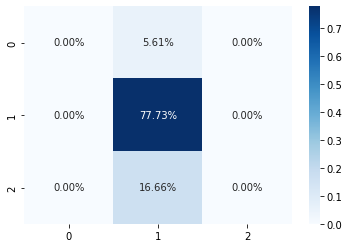

In [108]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

orig_cf = confusion_matrix(orig_test_df['class'], orig_test_df['predicted'])
sns.heatmap(orig_cf/np.sum(orig_cf), annot=True, fmt='.2%', cmap='Blues')

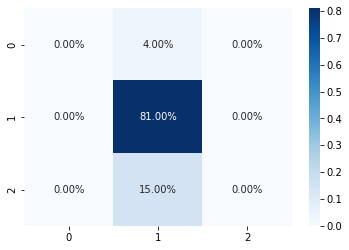

In [109]:
trans_cf = confusion_matrix(some_test_df['class'], some_test_df['predicted'])
sns.heatmap(trans_cf/np.sum(trans_cf), annot=True, fmt='.2%', cmap='Blues')

**If there is time: universal sentence encoder**

In [112]:
import tensorflow_hub as hub
import nltk


Load embedding tensor

In [119]:
encoder = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

In [146]:
universal_orig_encode = [i for i in some_test_df['tweet']]
universal_orig_encode[:10]

["It really ain't nothin to cut that bitch off",
 'Sex should be a reward in a relationship. Nigga has never done anything for you whatsoever yet you still give him the pussy...smh',
 'RT @tishforprez: that pointy nail game is for da birds.',
 "Ur no from here, u act sound infront ae me or I'll be an awfy cunt nd break ur fukin phone tae",
 'Shoulda put retard mikey on AHS freakshow',
 'Hoes be prayin niccas dnt kno dat background',
 "RT @TorahBlaze: @1SonofYahweh hell yea! I don't know what's wrong w the brothas that love these cave hoes so damn much... #StopItNow",
 'This bih stay in this ghetto ass neighborhood',
 '@dabbba @Pinchehonkey Far as I can tell coon tracks on the cab door window - tractor was parked by some trees away from home',
 'RT @Jarhead44: Hi, can I buy you a margarita?\n\nSure!\n\nSo, I like the way your barstool shows off your clam.']

In [147]:
universal_tweet_encode = [i for i in some_test_df['translated_tweets']]
universal_tweet_encode[:10]

["It really ain't nothin to cut that off",
 'Sex should be a reward in a relationship. Nigga has never done anything for you',
 'RT @tishforprez: that pointy nail game is for the birds',
 "u act sound infront ae me or I'll break ur phone tae",
 'Should put retard mikey on AHS freakshow',
 'Hoes be praying niccas dnt kno dat background',
 "RT @TorahBlaze: Yes! I don't know what's wrong w",
 'This bih stay in this ghetto neighborhood',
 '@dabbba @Pinchehonkey Far as I can tell coon',
 'RT @Jarhead44: Hi, can I buy you a margarita?']

In [ ]:
encoder([universal_tweet_encode[1]])

In [ ]:
# semantic similarity, but not sure if this is cosine similarity???
similarity = []
for x,y in zip(universal_orig_encode, universal_tweet_encode):
  new_list = [x,y]
  encoding_matrix = encoder(new_list)
  score = np.inner(encoding_matrix, encoding_matrix)
  #print(x,'\n',y,'\n', score,'\n') # score gives a matrix
  print(x,'\n',y,'\n','semantic similarity:', score[0][1],'\n')
  similarity.append(score[0][1])



In [159]:
some_test_df = pd.concat([some_test_df, pd.Series(similarity).rename('similarity')],axis=1)
some_test_df

,index,count,hate_speech,offensive_language,neither,class,tweet,translated_tweets,predicted,similarity
0,12206,3,1,2,0,1,It really ain't nothin to cut that bitch off,It really ain't nothin to cut that off,1,0.866555
1,21140,3,0,3,0,1,Sex should be a reward in a relationship. Nigg...,Sex should be a reward in a relationship. Nigg...,1,0.914660
2,20640,3,0,1,2,2,RT @tishforprez: that pointy nail game is for ...,RT @tishforprez: that pointy nail game is for ...,1,0.967746
3,22879,6,0,6,0,1,"Ur no from here, u act sound infront ae me or ...",u act sound infront ae me or I'll break ur pho...,1,0.834546
4,21256,3,1,2,0,1,Shoulda put retard mikey on AHS freakshow,Should put retard mikey on AHS freakshow,1,0.915224
...,...,...,...,...,...,...,...,...,...,...
95,23998,3,0,3,0,1,Your pussy hella tight. Took me an hour to sli...,You're tight. Took me an hour to slide in.,1,0.588648
96,7408,3,0,3,0,1,@triple6em96 @longbongchris stfu you stupid bi...,@triple6em96 @longbongchris stfu you? Like,1,0.529401
97,17341,3,0,3,0,1,RT @Prinncesskimm_: All my bitches attractive,RT @Prinncesskimm_: All my girls attractive,1,0.809459
98,15292,3,0,3,0,1,RT @DarlinCory: Making homemade pickles and wo...,RT @DarlinCory: Making homemade pickles and wo...,1,0.825072


STS (Semantic Textual Similarity) Benchmark


In [ ]:
pip install sentence-transformers

In [161]:
from sentence_transformers import SentenceTransformer, util

In [162]:
what = SentenceTransformer('stsb-roberta-large')

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/674 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [163]:
# testing semantic similarity between 2 tweets
sentence1 = universal_orig_encode[0]
sentence2 = universal_tweet_encode[0]
# encode sentences to get their embeddings
embedding1 = what.encode(sentence1, convert_to_tensor=True)
embedding2 = what.encode(sentence2, convert_to_tensor=True)
# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
print("Sentence 1:", sentence1)
print("Sentence 2:", sentence2)
print("Similarity score:", cosine_scores.item())

Sentence 1: It really ain't nothin to cut that bitch off
Sentence 2: It really ain't nothin to cut that off
Similarity score: 0.7116117477416992


In [ ]:
## Calculate semantic similarity between two lists of sentences
maybe_cos_score = []
# encode list of sentences to get their embeddings
embedding1 = what.encode(universal_orig_encode, convert_to_tensor=True)
embedding2 = what.encode(universal_tweet_encode, convert_to_tensor=True)
# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
for i in range(len(universal_orig_encode)):
  print("Sentence 1:", universal_orig_encode[i])
  print("Sentence 2:", universal_tweet_encode[i])
  score = cosine_scores[i][i].item()
  print("Similarity Score:", score)
  maybe_cos_score.append(score)
  print()

In [171]:
some_test_df = pd.concat([some_test_df, pd.Series(maybe_cos_score).rename('cos_similarity')],axis=1)
some_test_df

,index,count,hate_speech,offensive_language,neither,class,tweet,translated_tweets,predicted,similarity,cos_similarity
0,12206,3,1,2,0,1,It really ain't nothin to cut that bitch off,It really ain't nothin to cut that off,1,0.866555,0.711612
1,21140,3,0,3,0,1,Sex should be a reward in a relationship. Nigg...,Sex should be a reward in a relationship. Nigg...,1,0.914660,0.898217
2,20640,3,0,1,2,2,RT @tishforprez: that pointy nail game is for ...,RT @tishforprez: that pointy nail game is for ...,1,0.967746,0.962988
3,22879,6,0,6,0,1,"Ur no from here, u act sound infront ae me or ...",u act sound infront ae me or I'll break ur pho...,1,0.834546,0.710682
4,21256,3,1,2,0,1,Shoulda put retard mikey on AHS freakshow,Should put retard mikey on AHS freakshow,1,0.915224,0.988808
...,...,...,...,...,...,...,...,...,...,...,...
95,23998,3,0,3,0,1,Your pussy hella tight. Took me an hour to sli...,You're tight. Took me an hour to slide in.,1,0.588648,0.544429
96,7408,3,0,3,0,1,@triple6em96 @longbongchris stfu you stupid bi...,@triple6em96 @longbongchris stfu you? Like,1,0.529401,0.472690
97,17341,3,0,3,0,1,RT @Prinncesskimm_: All my bitches attractive,RT @Prinncesskimm_: All my girls attractive,1,0.809459,0.932930
98,15292,3,0,3,0,1,RT @DarlinCory: Making homemade pickles and wo...,RT @DarlinCory: Making homemade pickles and wo...,1,0.825072,0.699916


In [ ]:
def run_sts_benchmark(batch):
  sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_1'].tolist())), axis=1)
  sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_2'].tolist())), axis=1)
  cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
  clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
  scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi
  """Returns the similarity scores"""
  return scores

dev_scores = sts_data['sim'].tolist()
scores = []
for batch in np.array_split(sts_data, 10):
  scores.extend(run_sts_benchmark(batch))

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

In [139]:
def cosine_similarity(v1, v2):
    mag1 = np.linalg.norm(v1)
    mag2 = np.linalg.norm(v2)
    if (not mag1) or (not mag2):
        return 0
    return np.dot(v1, v2) / (mag1 * mag2)



In [145]:
cos_similarity = []
for x,y in zip(universal_orig_encode, universal_tweet_encode):
  original_tweet = [encoder(x)]
  translated_tweet = [encoder(y)]
  np.inner(original_tweet,translated_tweet)
  #similarity = cosine_similarity(original_tweet, translated_tweet)
  #cos_similarity.append(similarity)

In [142]:
why = encoder(universal_tweet_encode[1])

In [144]:
why.shape

TensorShape([1, 512])

In [132]:
len(universal_tweet_encode)

100